In [1]:
# Basic Libraries
import sys
import time
import gc
import random
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PyTorch Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Data Handling and Image Processing
from torchvision import datasets, transforms

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.metrics import structural_similarity as ssim

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Scientific Computing and Machine Learning
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import subspace_angles
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

# Custom Modules and Extensions
sys.path.append("../netrep/")
sys.path.append("../svcca/")

import networks as nets  # Contains RNNs
import net_helpers
import tasks
import helper
import mpn

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

# Memory Optimization
gc.collect()
torch.cuda.empty_cache()

In [2]:
# 0 Red, 1 blue, 2 green, 3 purple, 4 orange, 5 teal, 6 gray, 7 pink, 8 yellow
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',]
c_vals_l = ['#feb2b2', '#90cdf4', '#9ae6b4', '#d6bcfa', '#fbd38d', '#81e6d9', '#e2e8f0', '#fbb6ce', '#faf089',]
c_vals_d = ['#9b2c2c', '#2c5282', '#276749', '#553c9a', '#9c4221', '#285e61', '#2d3748', '#97266d', '#975a16',]
l_vals = ['solid', 'dashed', 'dotted', 'dashdot', '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10))]
markers_vals = ['o', 'v', '^', '<', '>', '1', '2', '3', '4', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
hyp_dict = {}

In [7]:
# Reload modules if changes have been made to them
from importlib import reload

reload(nets)
reload(net_helpers)

fixseed = False # randomize setting the seed may lead to not perfectly solved results
seed = random.randint(1,1000) if not fixseed else 8 # random set the seed to test robustness by default
print(f"Set seed {seed}")
np.random.seed(seed)
torch.manual_seed(seed)

hyp_dict['task_type'] = 'multitask' # int, NeuroGym, multitask
hyp_dict['mode_for_all'] = "random_batch"
hyp_dict['ruleset'] = 'delaygo' # low_dim, all, test

accept_rules = ('fdgo', 'fdanti', 'delaygo', 'delayanti', 'reactgo', 'reactanti', 
                'delaydm1', 'delaydm2', 'dmsgo', 'dmcgo', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dm1')


rules_dict = \
    {'all' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],
     'low_dim' : ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
                 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
                 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo'],

     'gofamily': ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti'],

     'delaygo': ['delaygo'],
     'delaygofamily': ['delaygo', 'delayanti'],
     'fdgo': ['fdgo'],
     'fdfamily': ['fdgo', 'fdanti'],
     'reactgo': ['reactgo'],
     'reactfamily': ['reactgo', 'reactanti'],
     
     'delaydm1': ['delaydm1'],
     'delaydmfamily': ['delaydm1', 'delaydm2'],
     
     'dmsgofamily': ['dmsgo', 'dmsnogo'],
     'dmsgo': ['dmsgo'],
     'dmcgo': ['dmcgo'],
     'contextdelaydm1': ['contextdelaydm1'], 
     'contextdelayfamily': ['contextdelaydm1', 'contextdelaydm2'],
    }
    

# This can either be used to set parameters OR set parameters and train
train = True # whether or not to train the network
verbose = True
hyp_dict['run_mode'] = 'minimal' # minimal, debug
hyp_dict['chosen_network'] = "dmpn"

# suffix for saving images
hyp_dict['addon_name'] = ""

mpn_depth = 1

# for coding 
if hyp_dict['chosen_network'] in ("gru", "vanilla"):
    mpn_depth = 1

def current_basic_params():
    task_params = {
        'task_type': hyp_dict['task_type'],
        'rules': rules_dict[hyp_dict['ruleset']],
        'dt': 40, # ms, directly influence sequence lengths,
        'ruleset': hyp_dict['ruleset'],
        'n_eachring': 8, # Number of distinct possible inputs on each ring
        'in_out_mode': 'low_dim',  # high_dim or low_dim or low_dim_pos (Robert vs. Laura's onetask, resp)
        'sigma_x': 0.00, # Laura raised to 0.1 to prevent overfitting (Robert uses 0.01)
        'mask_type': 'cost', # 'cost', None
        'fixate_off': True, # Second fixation signal goes on when first is off
        'task_info': True, 
        'randomize_inputs': False,
        'n_input': 20, # Only used if inputs are randomized,
        'modality_diff': False, # if two stimulus are included in the task, put them into different modality,
        'label_strength': False,
        'long_delay': 'normal',
        'adjust_task_prop': True,
        'adjust_task_decay': 0.9, 
    }

    print(f"Fixation_off: {task_params['fixate_off']}; Task_info: {task_params['task_info']}")

    train_params = {
        'lr': 1e-3,
        'n_batches': 128,
        'batch_size': 128,
        'gradient_clip': 10,
        'valid_n_batch': 200,
        'n_datasets': 500, # Number of distinct batches
        'n_epochs_per_set': 100, # longer/shorter training
        # 'task_mask': None, # None, task
        # 'weight_reg': 'L2',
        # 'reg_lambda': 1e-4,
    }

    if not train: # some 
        assert train_params['n_epochs_per_set'] == 0

    n_hidden = 50

    net_params = {
        'net_type': hyp_dict['chosen_network'], # mpn1, dmpn, vanilla
        'n_neurons': [1] + [n_hidden] * mpn_depth + [1],
        'output_bias': False, # Turn off biases for easier interpretation
        'loss_type': 'MSE', # XE, MSE
        'activation': 'tanh', # linear, ReLU, sigmoid, tanh, tanh_re, tukey, heaviside
        'cuda': True,
        'monitor_freq': 100,
        'monitor_valid_out': True, # Whether or not to save validation output throughout training
        'output_matrix': '',# "" (default); "untrained", or "orthogonal"
        'input_layer_add': False, # for one-task, probably no need to have input layer added
        'input_layer_add_trainable': False, # revise this is effectively to [randomize_inputs], tune this
        'input_layer_bias': False, 
        'input_layer': "trainable", # for RNN only
        'acc_measure': 'stimulus', 
        
        'ml_params0': {
            'bias': True, # Bias of layer
            'mp_type': 'mult',
            'm_update_type': 'hebb_assoc', # hebb_assoc, hebb_pre
            'eta_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'eta_train': True,
            # 'eta_init': 'gaussian', 
            'lam_type': 'scalar', # scalar, pre_vector, post_vector, matrix
            'm_time_scale': 400, # ms, sets lambda
            'lam_train': False,
            'W_freeze': False  
        },

        # Vanilla RNN params
        'leaky': True,
        'alpha': 0.2,
    }

    # actually I don't think it is needed
    # putting here to warn the parameter checking every time 
    # when switching network
    if hyp_dict['chosen_network'] in ("gru", "vanilla"):
        assert f'ml_params' in net_params.keys()

    return task_params, train_params, net_params

task_params, train_params, net_params = current_basic_params()

shift_index = 1 if not task_params['fixate_off'] else 0

if hyp_dict['task_type'] in ('multitask',):
    task_params, train_params, net_params = tasks.convert_and_init_multitask_params(
        (task_params, train_params, net_params)
    )

    net_params['prefs'] = tasks.get_prefs(task_params['hp'])

    print('Rules: {}'.format(task_params['rules']))
    print('  Input size {}, Output size {}'.format(
        task_params['n_input'], task_params['n_output'],
    ))
else:
    raise NotImplementedError()

if net_params['cuda']:
    print('Using CUDA...')
    device = torch.device('cuda')
else:
    print('Using CPU...')
    device = torch.device('cpu')

Set seed 176
Fixation_off: True; Task_info: True
Rules: ['delaygo']
  Input size 7, Output size 3
Using CUDA...


In [8]:
hyp_dict["mess_with_training"] = False

if hyp_dict['mess_with_training']:
    hyp_dict['addon_name'] += "messwithtraining"

params = task_params, train_params, net_params

# random matrix
random_matrix = None
if task_params["randomize_inputs"]:
    random_matrix = task_params["randomize_matrix"]

if net_params['net_type'] == 'mpn1':
    netFunction = mpn.MultiPlasticNet
elif net_params['net_type'] == 'dmpn':
    netFunction = mpn.DeepMultiPlasticNet
elif net_params['net_type'] == 'vanilla':
    netFunction = nets.VanillaRNN
elif net_params['net_type'] == 'gru':
    netFunction = nets.GRU

In [9]:
test_n_batch = train_params["valid_n_batch"]
color_by = "stim"

task_random_fix = True
if task_random_fix:
    print(f"Align {task_params['rules']} With Same Time")

if task_params['task_type'] in ('multitask',): # Test batch consists of all the rules
    task_params['hp']['batch_size_train'] = test_n_batch
    # using homogeneous cutting off
    test_mode_for_all = "random"
    # ZIHAN
    # generate test data using "random"
    test_data, test_trials_extra = tasks.generate_trials_wrap(task_params, test_n_batch, \
                rules=task_params['rules'], mode_input=test_mode_for_all, fix=task_random_fix)
    _, test_trials, test_rule_idxs = test_trials_extra

    task_params['dataset_name'] = 'multitask'

    if task_params['in_out_mode'] in ('low_dim_pos',):
        output_dim_labels = ('Fixate', 'Cos', '-Cos', 'Sin', '-Sin')
    elif task_params['in_out_mode'] in ('low_dim',):
        output_dim_labels = ('Fixate', 'Cos', 'Sin')
    else:
        raise NotImplementedError()

    labels = []
    for rule_idx, rule in enumerate(task_params['rules']):
        print(rule)
        if rule in accept_rules:
            if hyp_dict['ruleset'] in ('dmsgo', 'dmcgo'):
                labels.append(test_trials[rule_idx].meta['matches'])
            else:
                labels.append(test_trials[rule_idx].meta['resp1' if color_by == "resp" else 'stim1'])

        else:
            raise NotImplementedError()
    labels = np.concatenate(labels, axis=0).reshape(-1,1)

test_input, test_output, test_mask = test_data

permutation = np.random.permutation(test_input.shape[0])
test_input = test_input[permutation]
test_output = test_output[permutation]
test_mask = test_mask[permutation]
labels = labels[permutation]

test_input_np = test_input.detach().cpu().numpy()
test_output_np = test_output.detach().cpu().numpy()

n_batch_all = test_input_np.shape[0] # Total number of batches, might be different than test_n_batch
max_seq_len = test_input_np.shape[1]

if task_params["randomize_inputs"]: 
    rmat = task_params["randomize_matrix"]
    test_input_np = np.matmul(test_input_np, np.linalg.pinv(rmat))

print(test_input.shape)

Align ['delaygo'] With Same Time
rng reset with seed 4797
delaygo
torch.Size([200, 74, 7])


In [10]:
# we use net at different training stage on the same test_input
net, _, (counter_lst, netout_lst, db_lst, Winput_lst, Winputbias_lst, \
         Woutput_lst, Wall_lst, marker_lst, loss_lst, acc_lst) = net_helpers.train_network(params, 
                                                                                           device=device, 
                                                                                           verbose=verbose, 
                                                                                           train=train, 
                                                                                           hyp_dict=hyp_dict, 
                                                                                           netFunction=netFunction, 
                                                                                           test_input=[test_input]
)

[7, 50, 3]
MultiPlastic Net:
  output neurons: 3
  Act: tanh

=== Layer Specific Setup ===
7
  MP Layer0 parameters:
    n_neurons - input: 7, output: 50
    M matrix parameters:    update bounds - Max mult: 1.0, Min mult: -1.0
      type: mult // Update - type: hebb_assoc // Act fn: linear
      Eta: scalar (train) // Lambda: scalar (fixed) // Lambda_max: 0.90 (tau: 4.0e+02)
inputs_all paddled: (200, 161, 7)
task_params['rules_probs']: [1.]
Rule: delaygo
Rule delaygo seq_len 154, max_seq_len 154
inputs_all paddled: (128, 154, 7)
inputs_all: torch.Size([128, 154, 7])
test_input_: torch.Size([200, 74, 7])
Train parameters:
  Loss: MSE // LR: 1.00e-03 // Optim: adam
  Grad type: backprop // Gradient clip: 1.0e+01
Weight reg: None
Activity reg: None
valid_inputs_batch.shape: torch.Size([200, 161, 7])
Iter: 0, LR: 1.000e-03 - train_loss:9.257e-01, rounded train_acc:0.000, valid_loss:9.077e-01, rounded valid_acc:0.000
valid_inputs_batch.shape: torch.Size([200, 161, 7])
Iter: 100, LR: 1.000e

In [26]:
counter_lst

[0, 1, 4, 16, 29]

Done!


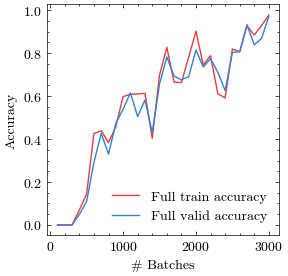

In [24]:
if train:
    fig, ax = plt.subplots(1,1,figsize=(3,3))
    ax.plot(net.hist['iters_monitor'][1:], net.hist['train_acc'][1:], color=c_vals[0], label='Full train accuracy')
    ax.plot(net.hist['iters_monitor'][1:], net.hist['valid_acc'][1:], color=c_vals[1], label='Full valid accuracy')
    if net.weight_reg is not None:
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_output_label'], color=c_vals_l[0], zorder=-1, label='Output label')
        ax.plot(net.hist['iters_monitor'], net.hist['train_loss_reg_term'], color=c_vals_l[0], zorder=-1, label='Reg term', linestyle='dashed')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_output_label'], color=c_vals_l[1], zorder=-1, label='Output valid label')
        ax.plot(net.hist['iters_monitor'], net.hist['valid_loss_reg_term'], color=c_vals_l[1], zorder=-1, label='Reg valid term', linestyle='dashed')
    
    # ax.set_yscale('log')
    ax.legend()
    # ax.set_ylabel('Loss ({})'.format(net.loss_type))
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('# Batches')
    plt.savefig(f"./onetask/loss_{hyp_dict['ruleset']}_{task_params['fixate_off']}.png")
    
print('Done!')

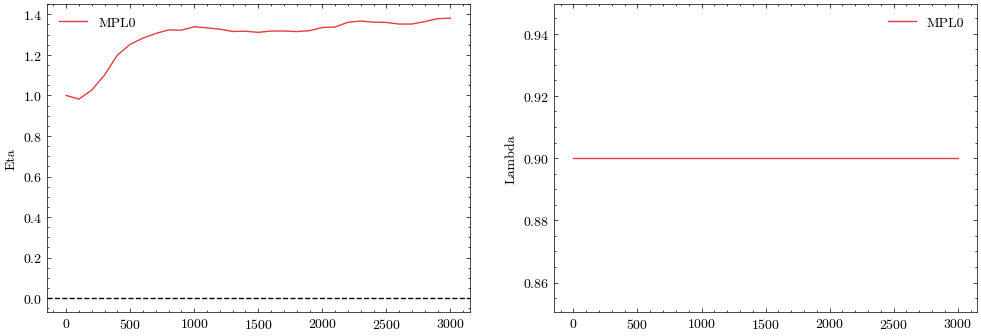

In [12]:
if train:
    net_helpers.net_eta_lambda_analysis(net, net_params, hyp_dict)

In [13]:
if hyp_dict['chosen_network'] == "dmpn":
    if net_params["input_layer_add"]:
        input_matrix = net.W_initial_linear.weight.data.detach().cpu().numpy()
        figinp, axsinp = plt.subplots(1,1,figsize=(4,4))
        sns.heatmap(input_matrix, ax=axsinp, square=True, cmap='coolwarm')

Using network at 100.0%


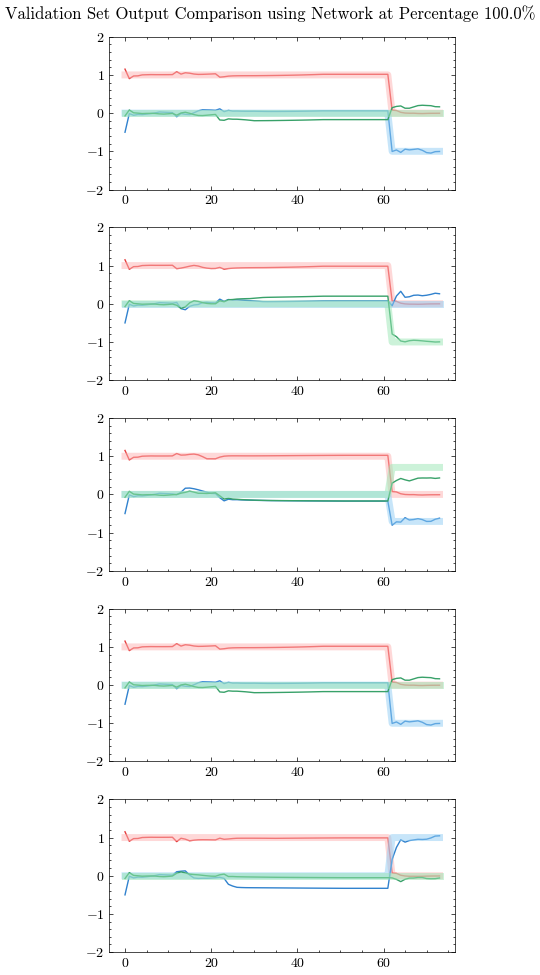

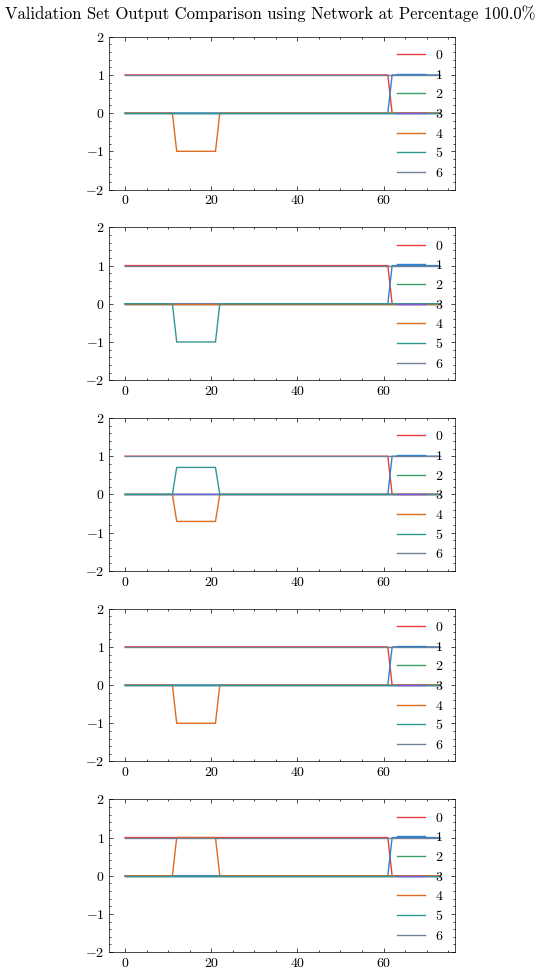

In [14]:
use_finalstage = False
if use_finalstage:
    # plotting output in the validation set
    net_out, db = net.iterate_sequence_batch(test_input, run_mode='track_states')
    W_output = net.W_output.detach().cpu().numpy()

    W_all_ = []
    for i in range(len(net.mp_layers)):
        W_all_.append(net.mp_layers[i].W.detach().cpu().numpy())
    W_ = W_all_[0]
    
else:
    ind = len(marker_lst)-1
    # ind = 0
    network_at_percent = (marker_lst[ind]+1)/train_params['n_datasets']*100
    print(f"Using network at {network_at_percent}%")
    net_out = netout_lst[0][ind]
    db = db_lst[0][ind]
    W_output = Woutput_lst[ind]
    if net_params["net_type"] == "dmpn":
        W_ = Wall_lst[ind][0]

if net_params['loss_type'] in ('MSE',):
    fig, axs = plt.subplots(5, 1, figsize=(4, 5*2))
    figin, axsin = plt.subplots(5, 1, figsize=(4, 5*2))

    if test_output_np.shape[-1] == 1:
        for batch_idx, ax in enumerate(axs):
            ax.plot(net_out[batch_idx, :, 0], color=c_vals[batch_idx])
            ax.plot(test_output_np[batch_idx, :, 0], color=c_vals_l[batch_idx])

    else:
        for batch_idx, ax in enumerate(axs):
            task_label = test_input_np[batch_idx, 0, 6-shift_index:]
            # task_label_index = np.where(task_label == 1)[0][0] 
            task_label_index = np.where(np.isclose(task_label, 1, atol=0.1))[0][0]
            for out_idx in range(test_output_np.shape[-1]):
                axs[batch_idx].plot(net_out[batch_idx, :, out_idx], color=c_vals[out_idx])
                axs[batch_idx].plot(test_output_np[batch_idx, :, out_idx], color=c_vals_l[out_idx], linewidth=5, alpha=0.5)
            axs[batch_idx].set_ylim([-2, 2])

            input_batch = test_input[batch_idx,:,:].cpu().numpy()
            for inp_idx in range(input_batch.shape[-1]):
                axsin[batch_idx].plot(input_batch[:,inp_idx], color=c_vals[inp_idx], label=inp_idx)
            axsin[batch_idx].legend()
            axsin[batch_idx].set_ylim([-2, 2])

    fig.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    fig.tight_layout()
    fig.savefig(f"./onetask/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}.png", dpi=300)

    figin.suptitle(f"Validation Set Output Comparison using Network at Percentage {network_at_percent}%")
    figin.tight_layout()
    figin.savefig(f"./onetask/lowD_{hyp_dict['ruleset']}_{hyp_dict['chosen_network']}_{hyp_dict['addon_name']}_input.png", dpi=300)

In [15]:
layer_index = 0 # 1 layer MPN 
if net_params["input_layer_add"]:
    layer_index += 1 

# here db is selected based on learning stage selection 
def modulation_extraction(db, max_seq_len, layer_index):
    """
    """
    n_batch_all_ = test_input.shape[0]
    
    Ms = np.concatenate((
        db[f'M{layer_index}'].reshape(n_batch_all_, max_seq_len, -1),
    ), axis=-1)

    Ms_orig = np.concatenate((
        db[f'M{layer_index}'],
    ), axis=-1)

    bs = np.concatenate((
        db[f'b{layer_index}'],
    ), axis=-1) 

    hs = np.concatenate((
        db[f'hidden{layer_index}'].reshape(n_batch_all_, max_seq_len, -1),
    ), axis=-1)

    xs = np.concatenate((
        db[f'input{layer_index}'].reshape(n_batch_all_, max_seq_len, -1),
    ), axis=-1)

    return Ms, Ms_orig, hs, bs, xs
    
if net_params["net_type"] in ("dmpn", ):
    if mpn_depth == 1:
        Ms, Ms_orig, hs, bs, xs = modulation_extraction(db_lst[0][-1], max_seq_len, layer_index)
        print(Ms_orig.shape)
    else:
        modulations, hiddens = [], []
        for i in range(mpn_depth):
            modulations.append(db[f'M{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1))
            hiddens.append(db[f'hidden{i}'].detach().cpu().numpy().reshape(n_batch_all, max_seq_len, -1),)

        Ms = modulations[0]
        hs = hiddens[0]
        
elif net_params["net_type"] in ("vanilla", "gru"):
    hs = db['hidden'].detach().cpu().numpy()

pca_type = 'full' # full, cell_types
pca_target_lst = ['hs', 'Ms'] # hs, 'Ms' 
if net_params["net_type"] in ("vanilla", "gru"):
    pca_target_lst = ['hs'] # if not dmpn, no M information effectively

# using recorded information
recordkyle_all, recordkyle_nameall = [], []
for test_subtrial in test_trials:
    metaepoch = test_subtrial.epochs
    periodname = list(metaepoch.keys())
    recordkyle, recordkyle_name = [], []
    for keyiter in range(len(periodname)):
        try:
            recordkyle_name.append(periodname[keyiter])
            if test_mode_for_all == "random":
                recordkyle.append(metaepoch[periodname[keyiter]][1])
            elif test_mode_for_all == "random_batch":
                recordkyle.append(list(metaepoch[periodname[keyiter]][1]))
        except Exception as e:
            print(e)
    
    if test_mode_for_all in ("random",):
        fillrecordkyle = []
        for timestamp in recordkyle:
            fillrecordkyle.append([timestamp for _ in range(hs.shape[0])])
        recordkyle = fillrecordkyle

    recordkyle.insert(0, [0 for _ in range(len(recordkyle[1]))])
    recordkyle = np.array(recordkyle).T.tolist()
    recordkyle_all.extend(recordkyle)
    recordkyle_nameall.append(recordkyle_name)

(200, 74, 50, 7)


In [16]:
# Sep 30th
# This part of code should be adaptive for multitask, which may have different breaks and periods for each task
unique_lists = set(tuple(lst) for lst in recordkyle_all)
# here select task specific information
# which maximally should have length of number of tasks
unique_recordkyle_all = [list(lst) for lst in unique_lists]
if not task_random_fix:
    assert len(unique_recordkyle_all) >= len(rules_dict[hyp_dict['ruleset']])
else:
    print("Test DataSet Random Seed Is Fixed")

all_session_breakdown = []
for task_specific_time in unique_recordkyle_all:
    session_breakdown = []
    for sindex in range(0,len(task_specific_time)-1):
        # all sessions should be the same for each task
        # but different across tasks
        # though the time of when response period starts might be similar across
        session_breakdown.append([task_specific_time[sindex], task_specific_time[sindex+1]]) 
    session_breakdown.append([task_specific_time[0], task_specific_time[-1]])
    all_session_breakdown.append(session_breakdown)

# break down time
all_breaks = []
for session_breakdown in all_session_breakdown:
    breaks = [cut[1] for cut in session_breakdown[:-1]]
    print(f"Task {all_session_breakdown.index(session_breakdown)}; breaks: {breaks}")
    all_breaks.append(breaks)

# for delay-task
assert len(all_breaks)
response_start = all_breaks[0][-2]
stimulus_start = all_breaks[0][0]
stimulus_end = all_breaks[0][1]
print(f"response_start: {response_start}")
print(f"stimulus_start: {stimulus_start}")
print(f"stimulus_end: {stimulus_end}")

Test DataSet Random Seed Is Fixed
Task 0; breaks: [12, 22, 62, 74]
response_start: 62
stimulus_start: 12
stimulus_end: 22


In [17]:
stages_num = len(Wall_lst) # how many recorded neurons in total
break_info = all_breaks[0]

input_nums = Ms_orig.shape[-1]
batch_nums = Ms_orig.shape[0]
neuron_nums = Ms_orig.shape[2]
colors = helper.generate_rainbow_colors(Ms_orig.shape[2])

def generate_random_orthonormal_matrix(N, num_columns=3):
    """
    generates an N x num_columns random matrix with orthonormal columns.
    """
    random_matrix = np.random.randn(N, num_columns)    
    Q, R = np.linalg.qr(random_matrix)    
    return Q[:, :num_columns]

In [31]:
# sanity check from equation 2-7
def plot_trajectory_by_index(label_index, stage_iter, verbose=False):
    """
    """
    W_ = Wall_lst[stage_iter][0]
    W_output = Woutput_lst[stage_iter]
    _, Ms_orig, _, bs, _ = modulation_extraction(db_lst[0][stage_iter], max_seq_len, layer_index) # batch * seq_len * hidden_neuron * input_neuron

    if verbose:
        figsize1, figsize2 = 2, 6
        figexh1, axsexh1 = plt.subplots(3,3,figsize=(figsize2*3,figsize1*3))  
        figexh2, axsexh2 = plt.subplots(4,3,figsize=(figsize2*3,figsize1*4))  
        figdiff, axsdiff = plt.subplots(1,2,figsize=(4*2,2))

    task_middle_dict = {}
    task_labels_across_batch = []

    saver_shape1 = (3,3)
    saver1 = np.empty((test_input.shape[0], saver_shape1[0], saver_shape1[1]), dtype=object)
    saver_shape2 = (4,3)
    saver2 = np.empty((test_input.shape[0], saver_shape2[0]+1, saver_shape2[1]), dtype=object)
    saver2_random = np.empty((test_input.shape[0], saver_shape2[0]+1, saver_shape2[1]), dtype=object) # projection to random space

    random_output_Y_lst = [generate_random_orthonormal_matrix(W_output.shape[1]) for _ in range(10)]

    for batch_iter in range(test_input.shape[0]):
        writeon = 0
        labels_for_batch = labels[batch_iter,0]
        
        if labels_for_batch in label_index: # >=0: for all label; ==0, say, for specific label on the ring (regardless on which task is using)
            xx = test_input[batch_iter, :, :].cpu().numpy()[0,6-shift_index:]
            which_task = np.where(xx)[0][0] # extract here, will repeat later at different time slices
            
            if labels_for_batch not in task_middle_dict.keys():
                task_middle_dict[which_task] = []
                writeon = 1
                
            x_batch_taskinfo = test_input[batch_iter, :, :][:,6-shift_index:].cpu().numpy()[0,:]
            task_specific = np.where(x_batch_taskinfo == 1)[0]
            assert len(task_specific) == 1
            task_specific = task_specific[0]
            
            task_labels_across_batch.append(task_specific) # load task information (which task) across batches
        
            res_eq26, res_eq8, res_eq11 = [], [], []
            res_meta = []

            for i in range(saver_shape1[0]):
                for j in range(saver_shape1[1]):
                    saver1[batch_iter, i, j] = np.array([])
        
            for i in range(saver_shape2[0]+1):
                for j in range(saver_shape2[1]):
                    saver2[batch_iter, i, j] = np.array([])
                    saver2_random[batch_iter, i, j] = np.array([])
        
            for time_iter in range(test_input.shape[1]):
                x = test_input[batch_iter, time_iter, :].cpu().numpy().reshape(-1,1)
                
                input_length = len(x)
        
                x_fixon, x_fixoff, x_stimulus, x_task = [np.zeros((input_length, 1)) for _ in range(4)]
                # one-hot encoded vector for fixation
                x_fixon[0,0] = x[0,0] 
                # one-hot encoded vector for fixation off (set to dummy if not presented)
                x_fixoff[1,0] = x[1,0] if task_params['fixate_off'] else 0
                # one-hot encoded vector for stimulus
                x_stimulus[2-shift_index:6-shift_index,0] = x[2-shift_index:6-shift_index,0]
                # one-hot encoded vector for task
                # task (dynamically setting for all element after the 6th elements)
                tasks_info = x[6-shift_index:,0]
                x_task[6-shift_index:,0] = tasks_info

                which_task = np.where(tasks_info)[0][0]
                
                Mt = Ms_orig[batch_iter, time_iter, :, :] 
                bt = bs[batch_iter, time_iter, :].reshape(-1,1) # hidden_neuron * 1
                
                middle =  W_ + W_ * Mt

                if time_iter >= response_start + 1 and len(label_index) == 1:
                    if writeon:
                        task_middle_dict[which_task].append(middle)
                
                y_fix = W_output[0,:].reshape(1,-1)
                Y_resp1 = W_output[1,:].reshape(1,-1)
                Y_resp2 = W_output[2,:].reshape(1,-1)

                if task_params['fixate_off']:
                    allX1 = [x_fixon+x_task, x_fixoff+x_task, x_stimulus+x_fixon+x_task]
                else:
                    allX1 = [x_fixon+x_task, x_task, x_stimulus+x_fixon+x_task]
                allX1name = ["x_fixon+x_task", "x_fixoff+x_task", "x_stimulus+x_fixon+x_task"]
                allX2 = [x_fixon, x_fixoff, x_stimulus, x_task]
                allX2name = ["x_fixon", "x_fixoff", "x_stimulus", "x_task"]
                allY = [y_fix, Y_resp1, Y_resp2]
                allYname = ["y_fix", "Y_resp1", "Y_resp2"]
        
                for yiter in range(len(allY)):
                    for xiter in range(len(allX1)):
                        # res1 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX1[xiter])
                        # print(middle.shape, allX1[xiter].shape)
                        step1 = middle @ allX1[xiter] + bt # adjust according to specific bias 
                        res1 = allY[yiter] @ step1 
                        saver1[batch_iter, xiter, yiter] = np.append(saver1[batch_iter, xiter, yiter], res1[0,0])
        
                for y1 in range(len(allY)):
                    for x1 in range(len(allX2)):
                        # res2 = helper.to_unit_vector(allY[yiter]) @ helper.to_unit_vector(middle @ allX2[xiter])
                        step1 = middle @ allX2[x1]
                        res2 = allY[y1] @ step1
                        res2_random = [((random_output_Y[:,y1].reshape(1,-1)) @ middle @ allX2[x1])[0,0] for random_output_Y in random_output_Y_lst]
                        
                        saver2[batch_iter, x1, y1] = np.append(saver2[batch_iter, x1, y1], res2[0,0])
                        saver2_random[batch_iter, x1, y1] = np.append(saver2_random[batch_iter, x1, y1], np.mean(res2_random))

                # how about bias projection to output
                for y_iter2 in range(len(allY)):
                    step1 = bt 
                    res2 = allY[y_iter2] @ step1
                    saver2[batch_iter, len(allX2), y_iter2] = np.append(saver2[batch_iter, len(allX2), y_iter2], res2[0,0])

            if verbose:
                for i in range(saver_shape1[0]):
                    for j in range(saver_shape1[1]):
                        axsexh1[i,j].plot(saver1[batch_iter,i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
            
                for i in range(saver_shape2[0]):
                    for j in range(saver_shape2[1]):            
                        axsexh2[i,j].plot(saver2[batch_iter,i,j], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
        
                # # extract fixon-task information explicitly
                axsdiff[0].plot(saver2[batch_iter,0,1] + saver2[batch_iter,3,1], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
                axsdiff[0].plot(saver2_random[batch_iter,0,1] + saver2_random[batch_iter,3,1], color=c_vals_l[labels_for_batch], linestyle=l_vals[task_specific])
                
                axsdiff[1].plot(saver2[batch_iter,0,2] + saver2[batch_iter,3,2], color=c_vals[labels_for_batch], linestyle=l_vals[task_specific])
                axsdiff[1].plot(saver2_random[batch_iter,0,2] + saver2_random[batch_iter,3,2], color=c_vals_l[labels_for_batch], linestyle=l_vals[task_specific])

    if verbose:
        # plot fixon/task information for one specific stimulus on one figure
        # show perfect cancellation until fixon info goes away (during response period)
        figpaper, axspaper = plt.subplots(8,1,figsize=(4, figsize1*8))

        temp_saver = []

        for batch_iter in range(test_input.shape[0]):
            labels_for_batch = labels[batch_iter,0]
            if labels_for_batch in label_index and labels_for_batch not in temp_saver:
                f_fixon, f_task, f_bias = saver2[batch_iter, 0, 1], saver2[batch_iter, 3, 1], saver2[batch_iter, -1, 1]
                axspaper[len(temp_saver)].plot(f_fixon, color=c_vals[0], linestyle=l_vals[0], label="Fixon")
                axspaper[len(temp_saver)].plot(f_task+f_bias, color=c_vals[1], linestyle=l_vals[1], label="Task+Bias")
                axspaper[len(temp_saver)].plot(f_fixon+f_task+f_bias, color=c_vals[2], linestyle=l_vals[3], linewidth=3, \
                                                       label="Combine")
                axspaper[len(temp_saver)].axhline(0, color=c_vals[3])

                temp_saver.append(labels_for_batch)

        for axsp in axspaper:
            axsp.legend()
            axsp.set_ylim([-2.0, 2.0])
        figpaper.tight_layout()   
        figpaper.savefig("./onetask/show.png")
        
        for i in range(saver_shape1[0]):
            for j in range(saver_shape1[1]):
                axsexh1[i,j].set_ylim([-2.0, 2.0])
                axsexh1[i,j].set_title(f"{allX1name[i]} & {allYname[j]}")
        
        for i in range(saver_shape2[0]):
            for j in range(saver_shape2[1]):
                axsexh2[i,j].set_ylim([-2.0, 2.0])
                axsexh2[i,j].set_title(f"{allX2name[i]} & {allYname[j]}")
        
        for ax in np.concatenate((axsexh1.flatten(), axsexh2.flatten())):
            for breaks in all_breaks:
                for bb in breaks:
                    ax.axvline(bb, linestyle="--", c=c_vals[all_breaks.index(breaks)])
    
        label_index_name = "all" if len(label_index) == 8 else label_index
        
        figexh1.suptitle(f"Exhaustive Search 1 {color_by} at Stage {stage_iter}")
        figexh1.tight_layout()
        figexh1.savefig(f"./onetask/es1_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")
        
        figexh2.suptitle(f"Exhaustive Search 2 {color_by} Stage {stage_iter}")
        figexh2.tight_layout()
        figexh2.savefig(f"./onetask/es2_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")

        axsdiff[0].set_title("Stimulus 1")
        axsdiff[1].set_title("Stimulus 2")
        figdiff.suptitle(f"Fixon-Task at Stage {stage_iter}")
        figdiff.tight_layout()
        figdiff.savefig(f"./onetask/diff_{task_params['fixate_off']}_{network_at_percent}_{label_index_name}.png")

    return task_middle_dict if len(label_index) == 1 else {}, task_labels_across_batch, saver2, saver2_random # only do it for single task learnig for clarity


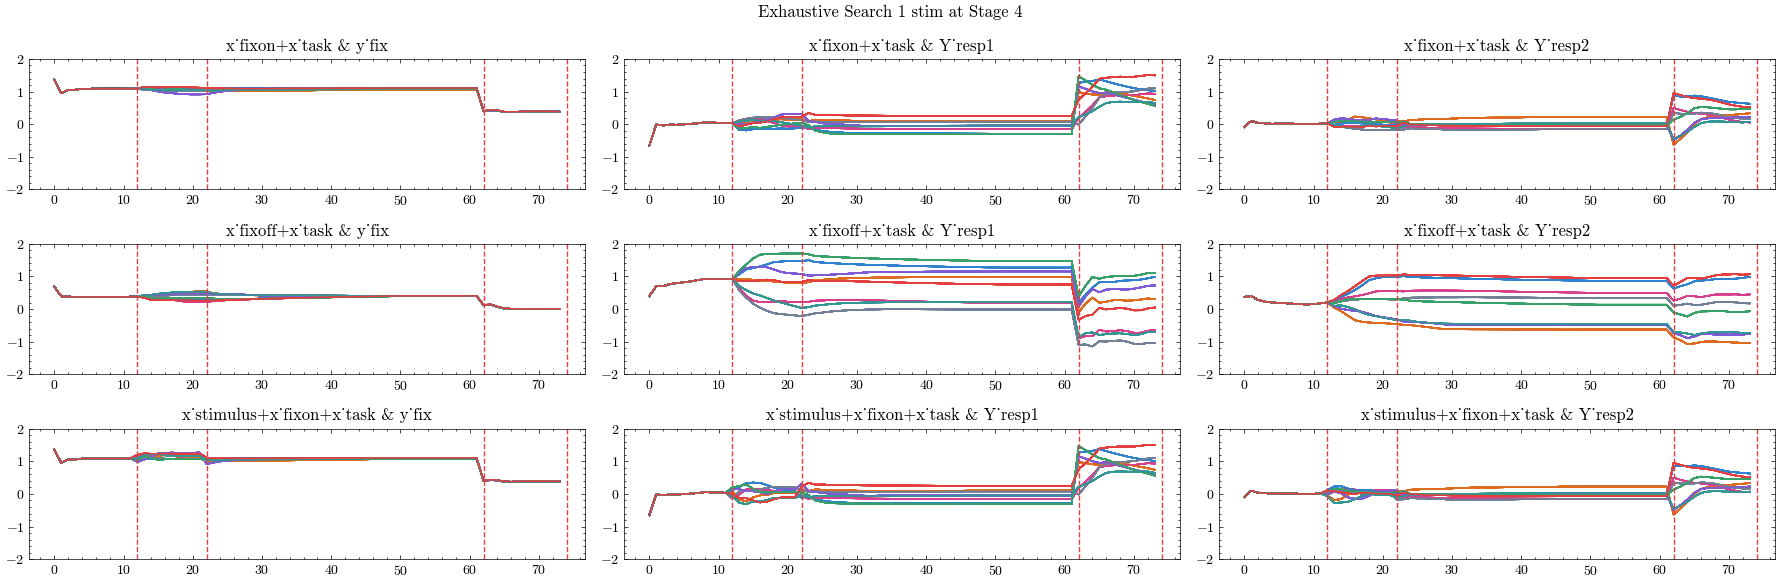

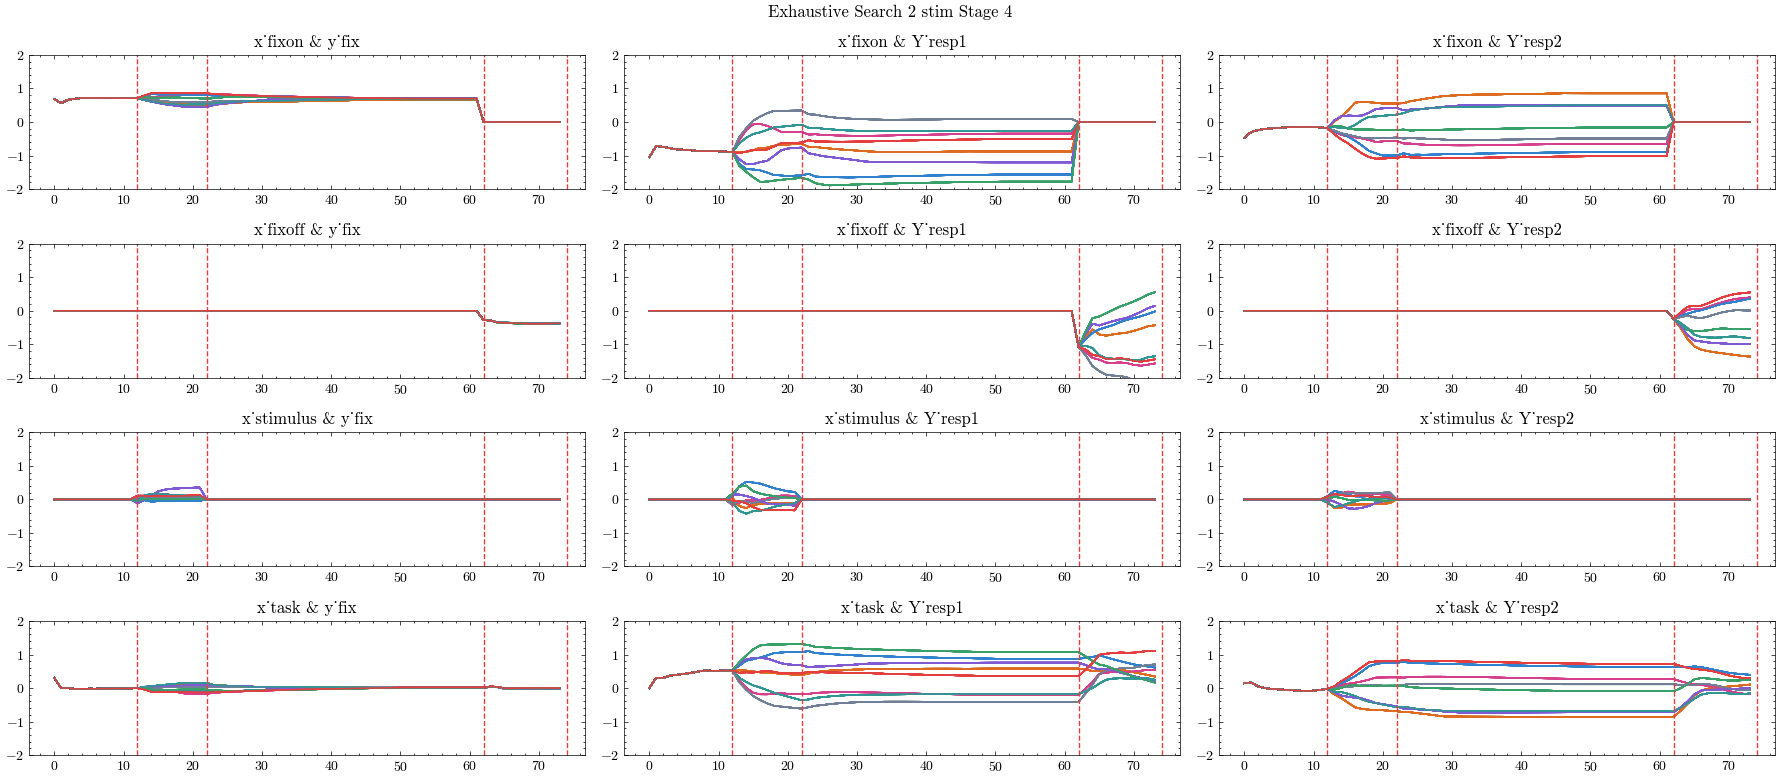

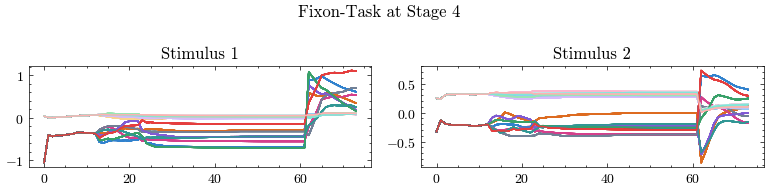

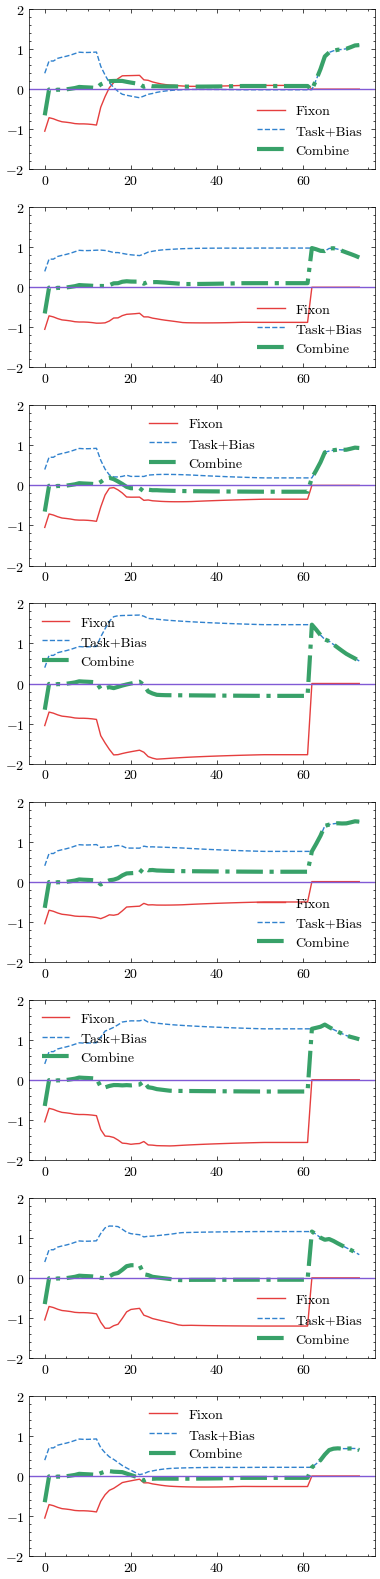

In [32]:
all_trajectory, all_trajectory_random = [], []
for stage_iter in range(stages_num):
    task_middle_dict, task_labels_across_batch, save_trajectory, save_trajectory_random = plot_trajectory_by_index(np.unique(labels), 
                                                                                                                   stage_iter, 
                                                                                                                   verbose=(stage_iter==stages_num-1)
)
    all_trajectory.append(save_trajectory)
    all_trajectory_random.append(save_trajectory_random)

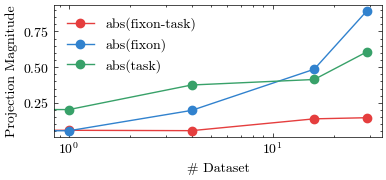

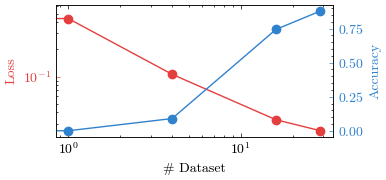

In [33]:
def analyze_trajectory(save_trajectory, save_trajectory_random):
    """
    Analyze trajectories by calculating mean absolute values for fixations and tasks.
    """
    def process_trajectory(trajectory, ind=False):
        results = []
        for batch in trajectory:
            stim1_fixon = batch[0, 1][stimulus_start:response_start]
            stim1_task = batch[3, 1][stimulus_start:response_start]
            if ind: 
                bias = batch[4, 1][stimulus_start:response_start]
            else:
                bias = np.zeros_like(stim1_fixon.shape)
                
            results.append([np.mean(np.abs(stim1_fixon + stim1_task + bias)), np.mean(np.abs(stim1_fixon)), np.mean(np.abs(stim1_task))])
        return np.array(results)
    
    # Process both trajectories
    result = process_trajectory(save_trajectory, True)
    result_random = process_trajectory(save_trajectory_random)
    
    # Return the mean of the computed values
    return np.mean(result[:, 0]), np.mean(result[:, 1]), np.mean(result[:,2]), np.mean(result_random[:, 0]), np.mean(result_random[:, 1]), np.mean(result_random[:, 2])

fixon_task_diff = np.array([analyze_trajectory(all_trajectory[i], all_trajectory_random[i]) for i in range(len(all_trajectory_random))])

figfixontaskcancel, axsfixontaskcancel = plt.subplots(figsize=(4,2))
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,0], "-o", c=c_vals[0], label="abs(fixon-task)")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,1], "-o", c=c_vals[1], label="abs(fixon)")
axsfixontaskcancel.plot(counter_lst, fixon_task_diff[:,2], "-o", c=c_vals[2], label="abs(task)")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,3], "-o", c=c_vals_l[0], label="abs(fixon-task) random")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,4], "-o", c=c_vals_l[1], label="abs(fixon) random")
# axsfixontaskcancel[0].plot(fixon_task_diff[:,5], "-o", c=c_vals_l[2], label="abs(task) random")
axsfixontaskcancel.legend()
axsfixontaskcancel.set_ylabel("Projection Magnitude")
# axsfixontaskcancel.set_title("Average Cancellation Effect Before Response Period")

axsfixontaskcancel.set_xlabel("# Dataset")
axsfixontaskcancel.set_xscale("log")
figfixontaskcancel.tight_layout()
figfixontaskcancel.savefig("./onetask/cancel.png")

fig, ax1 = plt.subplots(figsize=(4,2))  # Create a new figure

ax1.plot(counter_lst, loss_lst, "-o", c=c_vals[0], label="Loss")
ax1.set_ylabel("Loss", color=c_vals[0])
ax1.tick_params(axis='y', colors=c_vals[0])
ax1.set_yscale("log")  # Keep log scale for loss
ax1.set_xlabel("Counter")

# Create a second y-axis for accuracy (right)
ax2 = ax1.twinx()
ax2.plot(counter_lst, acc_lst, "-o", c=c_vals[1], label="Accuracy")
ax2.set_ylabel("Accuracy", color=c_vals[1])
ax2.tick_params(axis='y', colors=c_vals[1])

ax1.set_xlabel("# Dataset")
ax1.set_xscale("log")
fig.tight_layout()
fig.savefig("./onetask/loss_acc.png")

In [40]:
modulation_dict_diff_lst = []
modulation_dict_lst = []
hidden_output_dict_lst = []
hidden_dict_lst = []
hidden_all_dict_lst = []

fig = make_subplots(
    rows=1,
    cols=stages_num,
    specs=[[{'type': 'scatter3d'}] * stages_num],
    subplot_titles=[f"Stage {i+1}" for i in range(stages_num)]  # Add titles for each subplot
)

camera = dict(
    eye=dict(x=1.25, y=1.25, z=1.25),  # Position of the camera
    up=dict(x=0, y=0, z=1),            # Orientation of the camera
    center=dict(x=0, y=0, z=0),        # Focal point of the camera
)

for stage_iter in range(stages_num):
    Woutput = Woutput_lst[stage_iter]
    _, Ms_orig, hs, bs, _ = modulation_extraction(db_lst[0][stage_iter], max_seq_len, layer_index)
    
    hs_stimulus = hs[:,stimulus_start-1:stimulus_end,:]
    Ms_stimulus = Ms_orig[:,stimulus_start-1:stimulus_end,:,:]

    modulation_diff_dict, modulation_dict, hidden_output_dict, hidden_dict, hidden_all_dict = {}, {}, {}, {}, {}
    
    for batch_iter in range(batch_nums):
        hs_stimulus_batch = hs_stimulus[batch_iter,:,:]
        hs_stimulus_batch_output = hs_stimulus_batch @ Woutput.T

        trace = go.Scatter3d(
            x=hs_stimulus_batch_output[:, 0],
            y=hs_stimulus_batch_output[:, 1],
            z=hs_stimulus_batch_output[:, 2],
            mode='lines+markers', 
            line=dict(color=c_vals[labels[batch_iter][0]], width=2),  
            marker=dict(size=5, symbol='circle'), 
            name=f"Batch {batch_iter} - Stage {stage_iter}",
            showlegend=False 
        )
        fig.add_trace(trace, row=1, col=stage_iter + 1)
        
        # modulation 
        Ms_stimulus_fixon = Ms_stimulus[batch_iter,-1,:,0] - Ms_stimulus[batch_iter,0,:,0]
        Ms_stimulus_task = Ms_stimulus[batch_iter,-1,:,-1] - Ms_stimulus[batch_iter,0,:,-1]
        
        modulation_diff_dict[labels[batch_iter,0]] = Ms_stimulus_fixon # change of modulation on fixon during stimulus period
        modulation_dict[labels[batch_iter,0]] =  Ms_stimulus[batch_iter,-1,:,0]
        hidden_output_dict[labels[batch_iter,0]] = hs_stimulus_batch_output
        hidden_dict[labels[batch_iter,0]] = hs_stimulus_batch[-1,:]
        hidden_all_dict[labels[batch_iter,0]] = hs_stimulus_batch

    modulation_dict_diff_lst.append(modulation_diff_dict)
    modulation_dict_lst.append(modulation_dict)
    hidden_output_dict_lst.append(hidden_output_dict)
    hidden_dict_lst.append(hidden_dict)
    hidden_all_dict_lst.append(hidden_all_dict)

for stage_iter in range(stages_num):
    fig.update_layout(
        **{
            f"scene{stage_iter + 1}": dict(
                xaxis=dict(range=[-1.3, 1.3], title="X"),
                yaxis=dict(range=[-1.3, 1.3], title="Y"),
                zaxis=dict(range=[-1.3, 1.3], title="Z"),
                aspectmode='cube',  
                camera=camera,       
                domain=dict(
                    x=[stage_iter / stages_num, (stage_iter + 1) / stages_num - 0.02],  
                    y=[0, 1]  
                )
            )
        }
    )

fig.update_layout(
    title="3D Interactive Plot for Different Stages",
    height=600, 
    width=600 * stages_num, 
    margin=dict(l=10, r=10, t=50, b=10),  
)

output_file = "./save/3d_interactive_plot_compact.html"
fig.write_html(output_file)

print(f"Plot saved to {output_file}")

Plot saved to ./save/3d_interactive_plot_compact.html


Dictionary saved as: ./onetask_data/corr0.npz


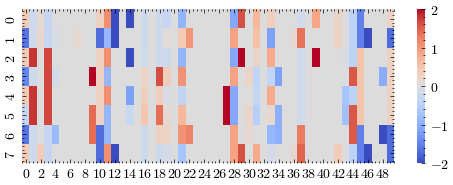

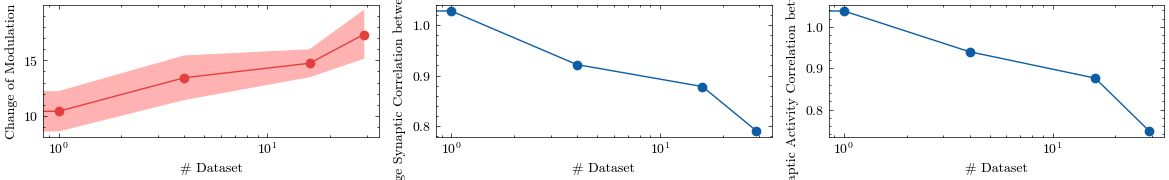

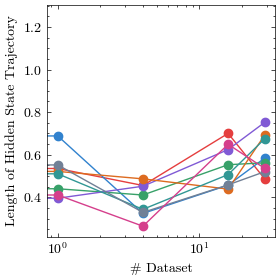

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

modulation_change_stage, m_corr_stage, h_corr_stage = [], [], []
fig_hc, axs_hc = plt.subplots(figsize=(6,2))

def binarize(arr, threshold):
    """"""
    return (np.abs(arr) > threshold).astype(int)

def normalized_participation_ratio(cov_matrix):
    """"""
    eigenvalues = np.linalg.eigvalsh(cov_matrix)  
    sum_eigen = np.sum(eigenvalues)
    sum_eigen_sq = np.sum(eigenvalues ** 2)    
    N = len(eigenvalues)
    npr = (sum_eigen ** 2) / (N * sum_eigen_sq)
    return npr
    
for i in range(stages_num):
    def analyze_hm_change(lst):
        md = lst[i]
        md_m = [np.array(value) for value in md.values()]
        md_m = np.column_stack(md_m)
        md_m = md_m.T # num_stimulus * hidden_size
        mc_stage = list(np.sum(np.abs(md_m), axis=1))
        # synptic_corr = np.corrcoef(md_m, rowvar=True)
        synptic_corr = cosine_similarity(md_m)
                
        mean_corr = np.nanmean(np.triu(synptic_corr))
        return mean_corr, mc_stage, md_m
        
    m_mean_corr, _, md_m = analyze_hm_change(modulation_dict_lst)
    m_diff_mean_corr, mc_stage, md_m_diff = analyze_hm_change(modulation_dict_diff_lst)
    h_mean_corr, _, md_h = analyze_hm_change(hidden_dict_lst)
        
    m_corr_stage.append(m_mean_corr)
    h_corr_stage.append(h_mean_corr)
    modulation_change_stage.append(mc_stage)

    if i == stages_num - 1:
        sns.heatmap(md_m_diff, ax=axs_hc, cmap="coolwarm")
        fig_hc.savefig("./onetask/modulation_heatmap.png")

modulation_change_stage = np.array(modulation_change_stage)

figmc,axsmc = plt.subplots(1, 3, figsize=(4*3,2))
# for i in range(modulation_change_stage.shape[1]):
#     axsmc[0].plot(counter_lst, modulation_change_stage[:,i], "-o", c=c_vals[i])
axsmc[0].plot(counter_lst, np.mean(modulation_change_stage, axis=1), "-o", c=c_vals[0])
axsmc[0].fill_between(counter_lst, np.mean(modulation_change_stage, axis=1) - np.std(modulation_change_stage, axis=1), \
                                   np.mean(modulation_change_stage, axis=1) + np.std(modulation_change_stage, axis=1), color=c_vals_l[0])
axsmc[0].set_ylabel("Change of Modulation")
# normalized? 
axsmc[1].plot(counter_lst, m_corr_stage/m_corr_stage[0], "-o")
axsmc[1].set_ylabel("Average Synaptic Correlation between Stimulus", fontsize=10)
axsmc[2].plot(counter_lst, h_corr_stage/h_corr_stage[0], "-o")
axsmc[2].set_ylabel("Postsynaptic Activity Correlation between Stimulus", fontsize=10)

import os 

def save_dict_with_count_npz(directory, data_dict, it=""):
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Count existing files in the directory
    file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

    # Generate filename based on file count
    filename = os.path.join(directory, f"{it}{file_count}.npz")

    # Save dictionary as an NPZ file
    np.savez(filename, **data_dict)

    print(f"Dictionary saved as: {filename}")


data_json = {"counter_lst": counter_lst, "m_corr_stage": m_corr_stage/m_corr_stage[0], "h_corr_stage": h_corr_stage/h_corr_stage[0]}
save_dict_with_count_npz("./onetask_data", data_json, it="corr")

for ax in axsmc:
    ax.set_xlabel("# Dataset")
    ax.set_xscale("log")
    
figmc.tight_layout()
figmc.savefig("./onetask/modulation_change.png")

def traj_length(array):
    """"""
    diffs = np.diff(array, axis=0)  
    return np.sum(np.linalg.norm(diffs, axis=1))

hidden_length_all = []
for stage_iter in range(stages_num):
    hidden_stage = hidden_output_dict_lst[stage_iter] 
    hidden_stage = {k: hidden_stage[k] for k in sorted(hidden_stage.keys())}
    hidden_length = [traj_length(arr) for arr in hidden_stage.values()]    
    hidden_length_all.append(hidden_length)
    
hidden_length_all = np.array(hidden_length_all)
figt, axst = plt.subplots(figsize=(3,3))
for i in range(hidden_length_all.shape[1]):
    axst.plot(counter_lst, hidden_length_all[:,i], "-o", c=c_vals[i])
axst.set_xlabel("# Dataset")
axst.set_xscale("log")
axst.set_ylabel("Length of Hidden State Trajectory")
figt.tight_layout()

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning:

Mean of empty slice.

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning:

invalid value encountered in scalar divide

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning:

Degrees of freedom <= 0 for slice

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning:

invalid value encountered in divide

/home/zihan.zhang/.conda/envs/mpn/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning:

invalid value encountered in scalar divide



IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

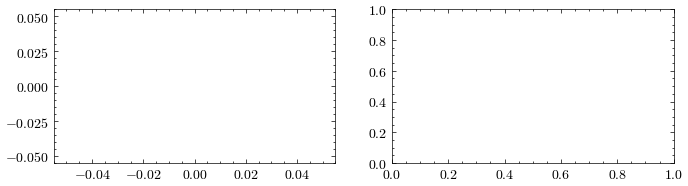

In [43]:
import glob
import os 

def load_all_npz_files(directory):
    npz_files = sorted(glob.glob(os.path.join(directory, "*.npz")))

    data_list = []
    for file in npz_files:
        data = np.load(file)  
        data_list.append({key: data[key] for key in data.files})  

        print(f"Loaded: {file}") 

    return data_list

plotall = True 
if plotall:
    directory = "./paper_data"
    all_data = load_all_npz_files(directory)
    counter_lst_all, m_corr_all, h_corr_all = [], [], []
    for i, data in enumerate(all_data):
        counter_lst_all.append(data["counter_lst"])
        m_corr_all.append(data["m_corr_stage"])
        h_corr_all.append(data["h_corr_stage"])

    counter_lst_all = np.array(counter_lst_all)
    m_corr_all = np.array(m_corr_all)
    h_corr_all = np.array(h_corr_all)

    mean_counter = np.mean(counter_lst_all, axis=0)
    mean_m_corr = np.mean(m_corr_all, axis=0)
    std_m_corr = np.std(m_corr_all, axis=0)
    
    mean_h_corr = np.mean(h_corr_all, axis=0)
    std_h_corr = np.std(h_corr_all, axis=0)
    
    figmcall, axsmcall = plt.subplots(1,2,figsize=(4*2,2))
    axsmcall[0].plot(mean_counter, mean_m_corr, "-o", label="Mean m_corr", color=c_vals[0])
    axsmcall[0].fill_between(mean_counter, mean_m_corr - std_m_corr, mean_m_corr + std_m_corr, color=c_vals_l[0], alpha=0.2)
    axsmcall[0].set_ylabel("Cos of Modulation", fontsize=10)
    axsmcall[1].plot(mean_counter, mean_h_corr, "-o", label="Mean h_corr", color=c_vals[0])
    axsmcall[1].fill_between(mean_counter, mean_h_corr - std_h_corr, mean_h_corr + std_h_corr, color=c_vals_l[0], alpha=0.2)
    axsmcall[1].set_ylabel("Cos of Hidden Activity", fontsize=10)
    for ax in axsmcall:
        ax.set_xlabel("# Dataset")
        ax.set_xscale("log")
    figmcall.tight_layout()
    figmcall.savefig("./onetask/modulation_analysis_during_learning.png")
    

    

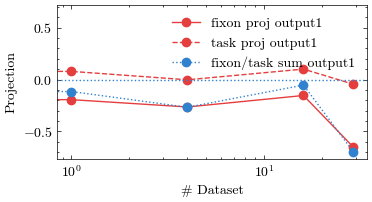

In [58]:
fixon_task_projoutput = []
for stage_iter in range(stages_num):
    W = Wall_lst[stage_iter][0]
    W_output = Woutput_lst[stage_iter]

    _, Ms_orig, _, bs, _ = modulation_extraction(db_lst[0][stage_iter], max_seq_len, layer_index) # batch * seq_len * hidden_neuron * input_neuron
    bias = np.mean(bs, axis=0)

    W_output_random_lst = [generate_random_orthonormal_matrix(W_output.shape[1]) for _ in range(10)]
    W_fixon = W[:,0].reshape(-1,1)
    W_task = W[:,5].reshape(-1,1)
    
    fixon_output, task_output = W_output[1:,:] @ W_fixon, W_output[1:,:] @ W_task
    bias_output = np.mean(bias @ (W_output[1:,:].T), axis=0)
    fixon_proj_output_norm1 = fixon_output[0] + bias_output[0]
    task_proj_output_norm1 = task_output[0] 
    fixon_proj_output_norm2 = fixon_output[1] + bias_output[1]
    task_proj_output_norm2 = task_output[1] 

    fixon_output_random, task_output_random = [(W_output_random.T @ W_fixon) for W_output_random in W_output_random_lst], [(W_output_random.T @ W_task) for W_output_random in W_output_random_lst]
    fixon_proj_output_norm_random = np.mean([np.sum(fixon_output_r) for fixon_output_r in fixon_output_random])
    task_proj_output_norm_random = np.mean([np.sum(task_output_r) for task_output_r in task_output_random])
    
    fixon_task_projoutput.append([fixon_proj_output_norm1[0], task_proj_output_norm1[0], 
                                  fixon_proj_output_norm2[0], task_proj_output_norm2[0], 
                                  fixon_proj_output_norm_random, task_proj_output_norm_random]
    )

fixon_task_projoutput = np.array(fixon_task_projoutput)

fig, ax = plt.subplots(figsize=(4,2))
ax.plot(counter_lst, fixon_task_projoutput[:, 0], marker="o", color=c_vals[0], linestyle=l_vals[0], label="fixon proj output1")
ax.plot(counter_lst, fixon_task_projoutput[:, 1], marker="o", color=c_vals[0], linestyle=l_vals[1], label="task proj output1")
ax.plot(counter_lst, fixon_task_projoutput[:, 0]+fixon_task_projoutput[:, 1], marker="o", color=c_vals[1], 
        linestyle=l_vals[2], linewidth=1, label="fixon/task sum output1")
ax.axhline(0, color=c_vals[1], linestyle=l_vals[2])

# ax.plot(counter_lst, fixon_task_projoutput[:, 2], "-o", color=c_vals[1], linestyle=l_vals[0], label="fixon proj output2")
# ax.plot(counter_lst, fixon_task_projoutput[:, 3], "-o", color=c_vals[1], linestyle=l_vals[1], label="task proj output2")
# ax.plot(counter_lst, fixon_task_projoutput[:, 2]+fixon_task_projoutput[:, 3], "-o", color=c_vals[1], linestyle=l_vals[2], linewidth=3, label="fixon/task sum output2")
# ax.plot(counter_lst, fixon_task_projoutput[:,2], "-o", c=c_vals_l[0], label="fixon proj output random")
# ax.plot(counter_lst, fixon_task_projoutput[:,3], "-o",c=c_vals_l[1], label="task proj output random")
ax.legend()    
ax.set_xlabel("# Dataset")
ax.set_xscale("log")
ax.set_ylabel("Projection")
fig.savefig("./onetask/w_to_output.png")

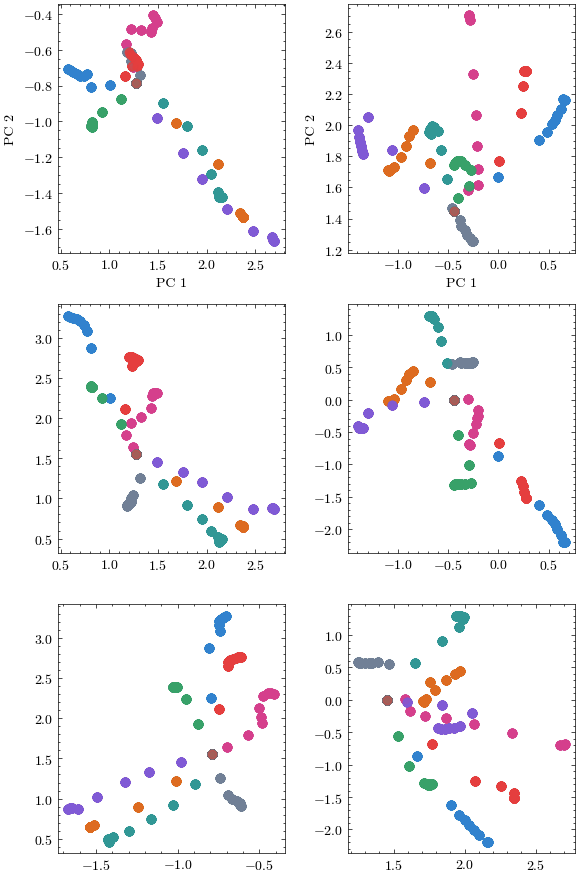

In [54]:
fighs, axshs = plt.subplots(3,2,figsize=(3*2,3*3))
pca_er_stage = []

start_stage = stages_num-2
for stage_iter in range(start_stage, stages_num):
    PCA_downsample = 3
    _, Ms_orig, hs, bs, _ = modulation_extraction(db_lst[0][stage_iter], max_seq_len, layer_index)

    prlst = [normalized_participation_ratio(np.cov(hs[i,:,:], rowvar=False)) for i in range(hs.shape[0])]

    pca = PCA(n_components = PCA_downsample)
    # # use hs 
    # hs_flattened = hs.reshape(hs.shape[0]*hs.shape[1], hs.shape[2])
    # hs_pca = pca.fit_transform(hs_flattened)
    # hs_reconstructed = hs_pca.reshape(hs.shape[0], hs.shape[1], PCA_downsample)
    # lowd_data = hs_reconstructed
    # # use Ms
    # Ms_flattened = Ms_orig.reshape(Ms_orig.shape[0] * Ms_orig.shape[1] * Ms_orig.shape[3], Ms_orig.shape[2])
    # ms_pca = pca.fit_transform(Ms_flattened)
    # Ms_reconstructed = ms_pca.reshape(Ms_orig.shape[0], Ms_orig.shape[1], Ms_orig.shape[3], PCA_downsample)
    # lowd_data_lst = [Ms_reconstructed[:,:,0,:]] # for instance, modulation of fixon
    Ms_end_of_stimulus = Ms_orig[:,stimulus_end:stimulus_end+1,:,:]
    Ms_end_of_stimulus_flattened = Ms_end_of_stimulus.reshape(Ms_end_of_stimulus.shape[0] * Ms_end_of_stimulus.shape[1] * Ms_end_of_stimulus.shape[3], 
                                                              Ms_end_of_stimulus.shape[2])
    pca.fit(Ms_end_of_stimulus_flattened)
    Ms_flattened = Ms_orig.reshape(Ms_orig.shape[0] * Ms_orig.shape[1] * Ms_orig.shape[3], Ms_orig.shape[2])
    projected_data = pca.transform(Ms_flattened)
    Ms_reconstructed = projected_data.reshape(Ms_orig.shape[0], Ms_orig.shape[1], Ms_orig.shape[3], PCA_downsample)

    lowd_data_lst = [Ms_reconstructed[:,:,0,:]] # for instance, modulation of fixon

    # pca_er_stage.append(pca.explained_variance_ratio_)
    
    for i in range(hs.shape[0]):
        for dd in range(len(lowd_data_lst)):
            lowd_data = lowd_data_lst[dd]
            data_batch = lowd_data[i,:,:]

            axshs[0,stage_iter-start_stage].scatter(data_batch[stimulus_start:stimulus_end,0], data_batch[stimulus_start:stimulus_end,1], 
                                                    marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.5)
            axshs[0,stage_iter-start_stage].set_xlabel("PC 1")
            axshs[0,stage_iter-start_stage].set_ylabel("PC 2")
            axshs[1,stage_iter-start_stage].scatter(data_batch[stimulus_start:stimulus_end,0], data_batch[stimulus_start:stimulus_end,2], 
                                                    marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.5)
            axshs[2,stage_iter-start_stage].scatter(data_batch[stimulus_start:stimulus_end,1], data_batch[stimulus_start:stimulus_end,2], 
                                                    marker=markers_vals[dd], c=c_vals[labels[i,0]], alpha=0.5)

fighs.tight_layout()
fighs.savefig("./onetask/m_pca.png")
